# Trying a new Training Notebook

Inspired by https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

In [17]:
import keras.backend as K
import keras
import numpy as np
import os
from scipy.misc import imread
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers, optimizers
from keras.models import Model
from DataGenerator import DataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.utils import multi_gpu_model
import tensorflow as tf


data_dir = 'ReducedTrainDatasets/Train2'
val_dir = 'ReducedValidationDataset'
val_pct = 0.15
batch_size = 64
epoch_scale_down_factor = 12
val_scale_down_factor = 2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_classes = 8763
class_dirs = os.listdir(data_dir)
image_list = []
labels = {}
cur_label = 0
class_to_labels = {}
for class_dir in class_dirs:
    class_dir_path = os.path.join(data_dir, class_dir)
    imgs = os.listdir(class_dir_path)
    for img in imgs:
        img_id = os.path.join(data_dir, class_dir, img)
        image_list.append(img_id)
        if class_dir in class_to_labels:
            labels[img_id] = class_to_labels[class_dir]
        else:
            class_to_labels[class_dir] = cur_label
            labels[img_id] = cur_label
            cur_label += 1

num_images = len(image_list)        
np.random.shuffle(image_list)

#partition = {'train':image_list[int(num_images*val_pct):], 'val':image_list[:int(num_images*val_pct)]}

In [3]:
num_classes = 8763
class_dirs = os.listdir(val_dir)
val_list = []
labels_val = {}
cur_label = 0
class_to_labels = {}
for class_dir in class_dirs:
    class_dir_path = os.path.join(val_dir, class_dir)
    imgs = os.listdir(class_dir_path)
    for img in imgs:
        img_id = os.path.join(val_dir, class_dir, img)
        val_list.append(img_id)
        if class_dir in class_to_labels:
            labels_val[img_id] = class_to_labels[class_dir]
        else:
            class_to_labels[class_dir] = cur_label
            labels_val[img_id] = cur_label
            cur_label += 1

num_images = len(val_list)        
np.random.shuffle(val_list)

In [18]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Set up some callbacks.

In [18]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=4, verbose=0, mode='auto')
tfboard = TensorBoard(log_dir='./logs5', batch_size=batch_size)
# checkpoint = ModelCheckpoint("checkpoints/checkpt-{epoch:02d}-{val_acc:.2f}.h5", 
#                              monitor='val_acc',
#                              verbose=0, 
#                              save_best_only=False, 
#                              save_weights_only=False,
#                              mode='auto', 
#                              period=3)

anneal = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                           patience=2)

callbacks = [tfboard, anneal, early]

In [22]:
def declare_model(reg=0):
    with tf.device('/cpu:0'):
        resnet = keras.applications.resnet50.ResNet50(include_top=False,
         weights="imagenet",
         input_shape=(224,224,3),
         pooling=None)
        # We will train the last 12 layers of ResNET and leave the others unchanged
        for layer in resnet.layers[:-12]:
            layer.trainable = False

        x = resnet.output
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        #x = Dense(num_classes, activation='relu', kernel_regularizer=regularizers.l2(reg))(x)
        scores = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(reg))(x)

        return Model(inputs=resnet.inputs, outputs=scores)

In [9]:
def gap(y_true, y_pred):
    # I actually cannot believe tensorflow is this popular.
    correct_labels = tf.to_int32(K.argmax(y_true, axis=1))
    pred_labels = tf.to_int32(K.argmax(y_pred, axis=1))
    hits = tf.equal(correct_labels, pred_labels)
    summands = tf.metrics.precision(correct_labels, pred_labels, weights=tf.to_int32(hits))
#     inds2 = tf.expand_dims(inds, 1)
#     range = tf.expand_dims(tf.range(tf.shape(inds)[0]), 1)
#     inds = tf.concat([range, inds2], 1)
#     selected = tf.gather_nd(y_pred, inds)
    # 5 LINES FOR SOME SIMPLE INDEXING!??!?!?
    sm =  K.sum(summands)
    denom = K.shape(y_true)[0]
    denom = tf.to_float(denom)
    return sm/denom

4707


In [23]:
K.clear_session()
model = declare_model(reg=1e-4)
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom=True)
adam = keras.optimizers.Adam(lr=2e-4)
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'], options=run_opts)

In [33]:
training_generator = DataGenerator(image_list, labels, epoch_scale_down_factor, batch_size=batch_size, n_classes=num_classes)
validation_generator = DataGenerator(val_list, labels_val, val_scale_down_factor, batch_size=batch_size, n_classes=num_classes)

mini_epochs = 3 * epoch_scale_down_factor

hist = parallel_model.fit_generator(generator=training_generator,
                           validation_data=validation_generator,
                           epochs=mini_epochs,
                           use_multiprocessing=True,
                           workers=6,
                           callbacks=callbacks,
                           initial_epoch=16)
print('Training Concluded')

parallel_model.save('models/train2_reduced_model.h5')

Epoch 17/36

 99/857 [==>...........................] - ETA: 6:55 - loss: 4.7887 - acc: 0.8447


198/857 [=====>........................] - ETA: 5:57 - loss: 4.7842 - acc: 0.8428


297/857 [=========>....................] - ETA: 5:01 - loss: 4.7960 - acc: 0.8398


396/857 [============>.................] - ETA: 4:08 - loss: 4.7890 - acc: 0.8401


495/857 [================>.............] - ETA: 3:14 - loss: 4.7773 - acc: 0.8425


594/857 [===================>..........] - ETA: 2:20 - loss: 4.7791 - acc: 0.8422


693/857 [=======================>......] - ETA: 1:27 - loss: 4.7816 - acc: 0.8415


793/857 [==========================>...] - ETA: 34s - loss: 4.7819 - acc: 0.8418


857/857 [==============================] - 529s 618ms/step - loss: 4.7841 - acc: 0.8417 - val_loss: 7.0471 - val_acc: 0.4179
Epoch 18/36

 36/857 [>.............................] - ETA: 7:35 - loss: 4.7905 - acc: 0.8338


135/857 [===>..........................] - ETA: 6:33 - loss: 4.8195 - acc: 0.8332


140/857 [===>..........................] - ETA: 6:30 - loss: 4.8158 - acc: 0.8337

Process ForkPoolWorker-492:
Process ForkPoolWorker-490:
Process ForkPoolWorker-491:
Process ForkPoolWorker-494:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-493:
Traceback (most recent call last):
Process ForkPoolWorker-489:
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.

KeyboardInterrupt: 

  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [34]:
# TODO:
# RUN AND CHANGE!!!
parallel_model.save_weights('models/train2_reduced_weights.h5')

4387


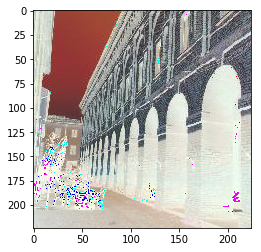

In [40]:
import matplotlib.pyplot as plt
idx = 4
X, y = training_generator[1000]
print(np.argmax(y[idx]))
plt.imshow(X[idx])
plt.show()

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


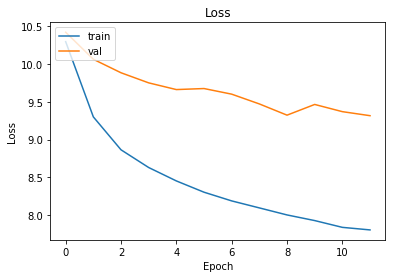

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plt.figure()
# plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
# plt.title('Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

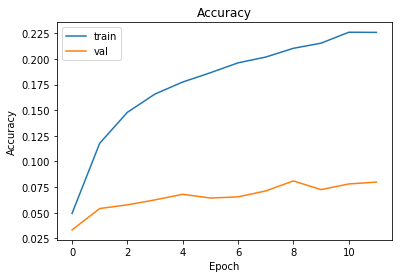

In [44]:
plt.figure()
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Text(0,0.5,'Learning Rate')

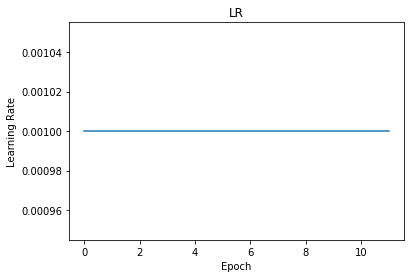

In [47]:
plt.figure()
plt.plot(hist.history['lr'])
plt.title('LR')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

In [32]:
print(K.get_value(parallel_model.optimizer.lr))
K.set_value(parallel_model.optimizer.lr, 5e-6)
print(K.get_value(parallel_model.optimizer.lr))


4e-05
5e-06
